# Empirical Exercise 7: The productivity-pay gap: Real or illusion?

You read papers arguing opposing views. Your goal in this exercise is to
understand the sources of disagreement and form your own conclusion.

To that end, our goal is to provide a decomposition of the differences between
productivity growth and wages similar to the analysis in Figure 2 of the
Stansbury and Summers paper. To what extent is the difference because of the
measure of compensation used? To what extent is it because of the measure of
inflation used?  

To answer these questions, you will draw on data from the CPS (the same as you
used for the last assignment) and FRED. The starting place is to compare the
growth of real productivity (output per hour) to the growth in real worker
compensation.

Starting with the median earnings of workers (deflated using the CPI), graph the
following to assess the importance of:

* Inequality and measured compensation:
    - Median earnings (CPI-deflated)
    - Average earnings (CPI-deflated)
    - Average compensation (CPI-deflated)
* Prices
    - Average compensation (PCE-deflated)
    - Average compensation (DBS-deflated)
    - Output per hour

Your well-labeled graph should have six lines that all start at "1" in 1962. 

In a few sentences describe your conclusions about whether or not American
workers are benefitting from rising productivity growth. Focus on “real” factors
(rather than measurement issues) such as rising inequality and changes in workers
“terms of trade” (differences in the prices of goods workers produce and they
consume).

In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from fredapi import Fred

In [2]:
key = ""
with open(f"../assets/fred.key", "r") as file:
    key = file.read()

fred = Fred(api_key = key)

In [3]:
features = "HCOMPBS OPHPBS PCEPI CPIAUCSL IPDBS".split()

fred_df = pd.DataFrame()
for f in features:
    series = fred.get_series(f)
    series.name = f
    fred_df[f] = series

fred_df = fred_df[fred_df.index.month == 4]
fred_df.index = fred_df.index.year
fred_df.head()

,HCOMPBS,OPHPBS,PCEPI,CPIAUCSL,IPDBS
1947,3.565,20.440,NaN,22.00,14.847
1948,3.845,21.407,NaN,23.82,15.897
1949,3.915,21.446,NaN,23.92,15.880
1950,4.195,23.373,NaN,23.65,15.793
1951,4.628,23.954,NaN,25.92,17.287


In [4]:
cps_df = pd.read_stata("../data/earnings.dta")
cps_df = cps_df[[
    "year",
    "incwage",
    "incbus",
    "incfarm"
]]

wage_cols = [
    "incwage",
    "incbus",
    "incfarm"
]

# Set top-codes to 0
for c in wage_cols:
    cps_df[c] = cps_df[c].replace(99999999, np.nan)
    cps_df[c] = cps_df[c].replace(99999998, np.nan)

# Sum the total income for each individual
cps_df["inctot"] = np.sum(cps_df[wage_cols], axis=1)
cps_df = cps_df[["year", "inctot"]]

# Drop zero-dollar earners
cps_df["inctot"] = cps_df["inctot"].replace(0, np.nan)

# Note: incomes are only reported in the March CPS - after this, the only month
# remaining in cps_df will be March.cps_df[c] = cps_df[c].replace(99999998, np.nan)
cps_df = cps_df.dropna()
cps_df

grp_df = cps_df.groupby(
    by = ["year"]
)["inctot"]

stat_df = pd.DataFrame()
stat_df["count"] =  grp_df.count()
stat_df["sum"] =  grp_df.sum()
stat_df["median"] =  grp_df.median()
stat_df["mean"] =  grp_df.mean()

stat_df.head()

,count,sum,median,mean
year,,,,
1962,32733,120629618.0,3000.0,3685.260074
1963,21725,82334851.0,3154.0,3789.866559
1964,33789,134519222.0,3328.0,3981.154281
1965,33760,140925834.0,3500.0,4174.343424
1966,68072,298278451.0,3700.0,4381.808247


In [5]:
# Now, we need to deflate these figures to 1968 standards. We'll create a df
# of index multipliers to do this.
base_year = 1962

idx_df = pd.DataFrame()

idx_df["cpi"] = fred_df["CPIAUCSL"] / fred_df["CPIAUCSL"].loc[base_year]
idx_df["pce"] = fred_df["PCEPI"] / fred_df["PCEPI"].loc[base_year]
idx_df["dbs"] = fred_df["IPDBS"] / fred_df["IPDBS"].loc[base_year]
idx_df["oph"] = fred_df["OPHPBS"] / fred_df["OPHPBS"].loc[base_year]

idx_df = idx_df.drop(idx_df[idx_df.index < base_year].index, axis=0)

idx_df.head()

,cpi,pce,dbs,oph
1962,1.000000,1.000000,1.000000,1.000000
1963,1.008937,1.009043,1.005089,1.037048
1964,1.024495,1.026000,1.016008,1.078761
1965,1.038729,1.039327,1.032362,1.104192
1966,1.068520,1.063958,1.054249,1.162579


      cpi_avg_earn  cpi_med_earn  cpi_avg_comp  pce_avg_comp  dbs_avg_comp  \
year                                                                         
2016      1.689819      1.474736      1.768337      2.266059      2.713204   
2017      1.714158      1.484071      1.785836      2.298002      2.760015   
2018      1.722090      1.506426      1.807067      2.332795      2.791424   
2019      1.751883      1.577591      1.845130      2.391339      2.865402   
2020      1.847461      1.572298      1.995308      2.582446      3.119495   

           oph  
year            
2016  3.101544  
2017  3.135251  
2018  3.201914  
2019  3.258374  
2020  3.348391  


<AxesSubplot:xlabel='year'>

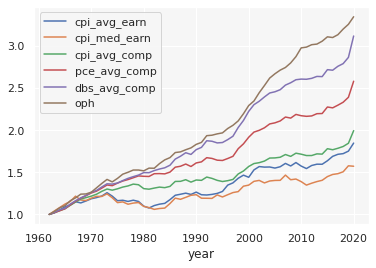

In [44]:
df = pd.DataFrame()

# Deflate average and median earnings with CPI
df["cpi_avg_earn"] = stat_df["mean"] / idx_df["cpi"]
df["cpi_med_earn"] = stat_df["median"] / idx_df["cpi"]

# Deflate average compensation with CPI
df["cpi_avg_comp"] = fred_df["HCOMPBS"] / idx_df["cpi"]

# Deflate average compensation with PCE
df["pce_avg_comp"] = fred_df["HCOMPBS"] / idx_df["pce"]

# Deflate average compensation with BSD
df["dbs_avg_comp"] = fred_df["HCOMPBS"] / idx_df["dbs"]

df["oph"] = idx_df["oph"]

for column in df.columns:
    df[column] = df[column] / df[column].iloc[0]

print(df.tail())
df.plot()

In [41]:
fred_df["OPHPBS"]

1947     20.440
1948     21.407
1949     21.446
1950     23.373
1951     23.954
         ...   
2016    103.055
2017    104.175
2018    106.390
2019    108.266
2020    111.257
Name: OPHPBS, Length: 74, dtype: float64

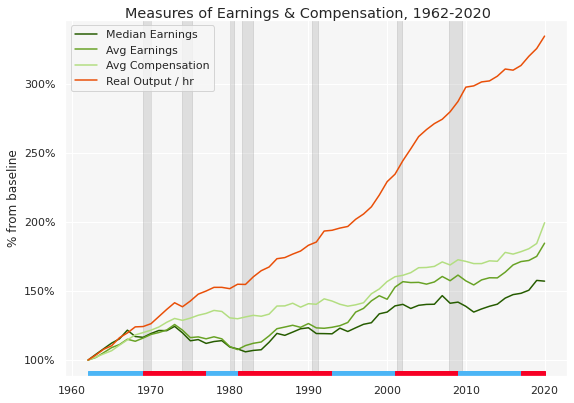

In [45]:
# Let's make this pretty!
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns 
import matplotlib.ticker as mtick

sns.set_theme()
sns.set(rc={'axes.facecolor':'#F6F6F6', 'figure.facecolor':'#FFFFFF'})

# Setting up the plot surface
fig = plt.figure(figsize=(9,6))
plt.suptitle("Measures of Earnings & Compensation, 1962-2020")
fig.subplots_adjust(top=0.95)
gs = GridSpec(nrows=1, ncols=1)

ax0 = fig.add_subplot(gs[0,:])
ax0.plot(df["cpi_med_earn"], color = "#265c00",
         label = "Median Earnings")
ax0.plot(df["cpi_avg_earn"], color = "#68a225",
         label = "Avg Earnings")
ax0.plot(df["cpi_avg_comp"], color = "#b3de81",
         label = "Avg Compensation")
# ax0.plot(df["pce_avg_comp"], color = "#faaf08",
#          label = "Avg Compensation (PCE-deflated)")
# ax0.plot(df["dbs_avg_comp"], color = "#fa812f",
#          label = "Avg Compensation (DBS-deflated)")
ax0.plot(df["oph"], color = "#e94f08",
         label = "Real Output / hr")
ax0.legend(loc="upper left")
ax0.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax0.set_ylabel("% from baseline")

presidents = [
    [1962, "#4cb5f5"],
    [1963, "#4cb5f5"],
    [1969, "#f70025"],
    [1974, "#f70025"],
    [1977, "#4cb5f5"],
    [1981, "#f70025"],
    [1989, "#f70025"],
    [1993, "#4cb5f5"],
    [2001, "#f70025"],
    [2009, "#4cb5f5"],
    [2017, "#f70025"],
    [2020, "_"],
]

recessions = [
    [1969, 1970],
    [1973.9, 1975.25],
    [1980, 1980.5],
    [1981.5, 1982.9],
    [1990.5, 1991.25],
    [2001.25, 2001.9],
    [2007.9, 2009.5],
]
 
for i in range(len(recessions)):
    ax0.axvspan(recessions[i][0], recessions[i][1], color="grey", alpha=0.2)

for i in range(len(presidents) - 1):
    ax0.axvspan(presidents[i][0], presidents[i + 1][0], color=presidents[i][1], alpha=1, ymin = 0, ymax=0.015)

plt.savefig("analysis.png")
plt.savefig("analysis.pdf")

In [ ]:
# Let's make this pretty!
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns 
import matplotlib.ticker as mtick

sns.set_theme()
sns.set(rc={'axes.facecolor':'#F6F6F6', 'figure.facecolor':'#FFFFFF'})

# Setting up the plot surface
fig = plt.figure(figsize=(12,8))
plt.suptitle("Measures of Earnings & Compensation, 1962-2020")
fig.subplots_adjust(top=0.95)
gs = GridSpec(nrows=1, ncols=1)

ax0 = fig.add_subplot(gs[0,:])
ax0.plot(df["cpi_med_earn"], color = "#003b46",
         label = "Median Earnings")
# ax0.plot(df["cpi_avg_earn"], color = "#66a5ad",
#          label = "Avg Earnings (CPI-Deflated")
ax0.plot(df["cpi_avg_comp"], color = "#b4cfd6",
         label = "Avg Compensation")
# ax0.plot(df["pce_avg_comp"], color = "#faaf08",
#          label = "Avg Compensation (PCE-deflated)")
# ax0.plot(df["dbs_avg_comp"], color = "#fa812f",
#          label = "Avg Compensation (DBS-deflated)")
ax0.plot(df["oph"], color = "#fa4032",
         label = "Real Output / hr")
ax0.legend(loc="upper left")
ax0.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax0.set_ylabel("% from baseline")

presidents = [
    [1962, "#4cb5f5"],
    [1963, "#4cb5f5"],
    [1969, "#f70025"],
    [1974, "#f70025"],
    [1977, "#4cb5f5"],
    [1981, "#f70025"],
    [1989, "#f70025"],
    [1993, "#4cb5f5"],
    [2001, "#f70025"],
    [2009, "#4cb5f5"],
    [2017, "#f70025"],
    [2020, "_"],
]

recessions = [
    [1969, 1970],
    [1973.9, 1975.25],
    [1980, 1980.5],
    [1981.5, 1982.9],
    [1990.5, 1991.25],
    [2001.25, 2001.9],
    [2007.9, 2009.5],
]
 
for i in range(len(recessions)):
    ax0.axvspan(recessions[i][0], recessions[i][1], color="grey", alpha=0.2)

for i in range(len(presidents) - 1):
    ax0.axvspan(presidents[i][0], presidents[i + 1][0], color=presidents[i][1], alpha=1, ymin = 0, ymax=0.015)

plt.savefig("analysis2.png")